In [1]:
import os
import pandas as pd
os.chdir("E:\\Projects\\diffusion")
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import warnings
from tqdm.auto import tqdm
import numpy as np
from diffusers.utils import randn_tensor
from stadiff.models import SpaUNet1DModel
from stadiff.pipeline import prepare_dataset
import torch.nn.functional as F
from diffusers import DDPMScheduler
from collections import defaultdict
from torch_geometric.loader import NeighborLoader
from stadiff.analytics import mclust_R
from stadiff import utils
os.environ["R_HOME"] = r"D:\Program Files\R\R-4.0.3"
warnings.filterwarnings("ignore")
sns.set_theme("paper", style="ticks", font_scale=1.25)
DATA_DIR = "E:\Projects\Datasets\J20-mouse\\rep3"


In [2]:
class RCTDDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self._adata = None
        self._read_data()

    def _read_data(self):
        adata = sc.read_mtx(os.path.join(self.data_dir, "counts.mtx")).T
        adata.obs_names = pd.read_csv(os.path.join(self.data_dir, "obs_names.csv"), index_col=False).iloc[:, 0]
        adata.var_names = pd.read_csv(os.path.join(self.data_dir, "gene_names.csv"), index_col=False).iloc[:, 0]
        adata.obs = pd.read_csv(os.path.join(self.data_dir, "resutls_df.csv"), index_col=0)
        coord = pd.read_csv(os.path.join(self.data_dir, "coord.csv"), index_col=0)
        adata.obsm["spatial"] = coord.iloc[:, :2].values
        self._adata = adata

    @property
    def adata(self):
        return self._adata


In [4]:
# load coord
rctd = RCTDDataset(DATA_DIR)
adata = rctd.adata
adata = adata[adata.obs["spot_class"] != "reject", :]

In [5]:
rare_celltypes = adata.obs["first_type"].value_counts() < 100
rare_celltypes = rare_celltypes.index[rare_celltypes.values]
adata = adata[~adata.obs["first_type"].isin(rare_celltypes)]

In [6]:
adata.obs["first_type"].value_counts()

Astrocyte                5625
Oligodendrocyte          2888
CA3                      1814
Denate                   1341
CA1                      1033
Entorihinal               851
Interneuron               827
Microglia_Macrophages     476
Endothelial_Tip           367
Polydendrocyte            171
Neuron.Slc17a6            129
Name: first_type, dtype: int64

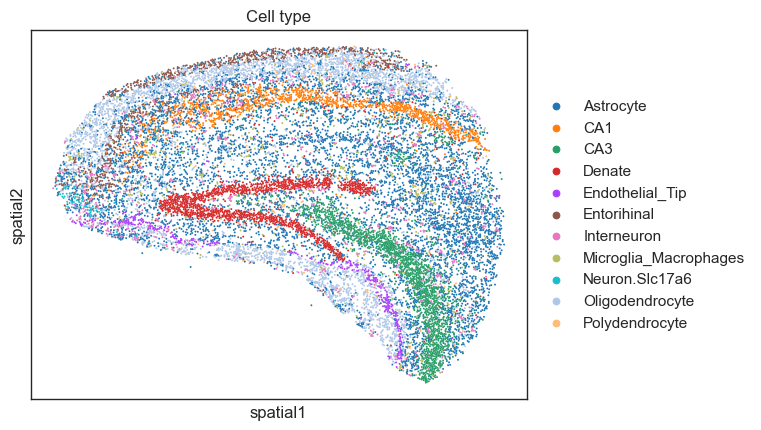

In [7]:
sc.pl.embedding(adata, basis="spatial", color="first_type", title="Cell type")

In [8]:
# high variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat_v3")
adata = adata[:, adata.var["highly_variable"]]

[ 976.  1185.7] [4810.7 4584.8]
Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.025, mean deviation: 0.24922352145342105, pearson correlation: 0.9999341023737499
Quantize 1th dimension of spatial coordinates to 0.025, mean deviation: 0.24891702100244817, pearson correlation: 0.9998986908162311
[0. 0.] [96. 85.]


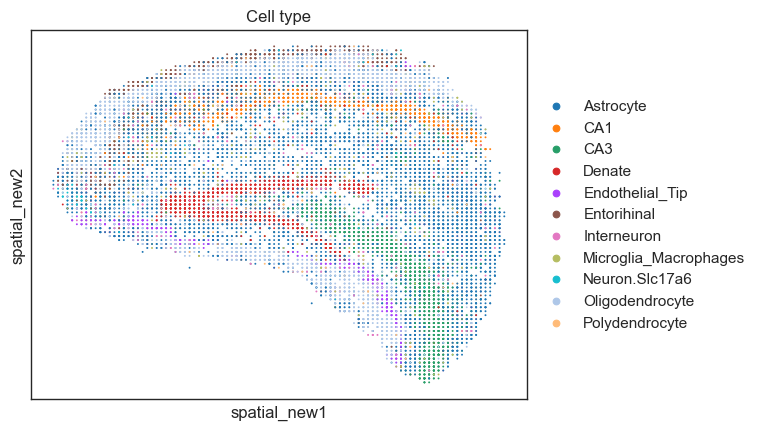

In [15]:
import stadiff.utils as utils
spatial_new = adata.obsm["spatial"].copy()
print(spatial_new.min(axis=0), spatial_new.max(axis=0))
spatial_new = utils.quantize_coordination(spatial_new, methods=[("division", 40), ("division", 40)])
adata.obsm["spatial_new"] = spatial_new
print(spatial_new.min(axis=0), spatial_new.max(axis=0))
sc.pl.embedding(adata, basis="spatial_new", color="first_type", title="Cell type")

In [17]:
adata = utils.cal_spatial_net2D(adata, rad_cutoff="30", use_obsm="spatial")

------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 91360 edges, 15522 cells, 5.8858 neighbors per cell on average.


In [18]:
sc.pp.log1p(adata)

## Training the autoencode

In [12]:
def eval_model(model, data, adata, add_key):
    model.eval()
    with torch.no_grad():
        z, out = spa_ae(data.x, data.edge_index)
    adata.obsm[add_key] = z.detach().cpu().numpy()
    adata = utils.mclust_R(adata, 7, used_obsm=add_key, add_key=add_key + "_mclust", random_seed=2023)
    sc.pp.neighbors(adata, use_rep=add_key, n_neighbors=30)
    sc.tl.umap(adata, min_dist=0.5)
    sc.pl.umap(adata, color=[add_key + "_mclust"], ncols=1, frameon=False, wspace=0.4, use_raw=False)

In [14]:
from stadiff.vae import SpaAE
from stadiff.dataset import get_slice_loader
from stadiff import pipeline
model_config = {"pretrain_epochs": 500,
                "align_epochs": 500,
                "diffusion_epochs": 2000,
                "gradient_clip": 5,
                "save_dir": "E:\Projects\diffusion\output\Hippocampus_condition",
                }
save_dir = model_config["save_dir"]
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
device = torch.device("cuda:0")
data = pipeline.prepare_dataset(adata, use_net="Spatial_Net").to(device)
loader = NeighborLoader(data, num_neighbors=[5, 5],batch_size=256)

In [15]:
spa_ae = SpaAE(input_dim=3000,
               block_list=["ResBlock"],
               gat_dim=[512, 32],
               block_out_dims=[32, 32]).to(device)

  0%|          | 0/1000 [00:00<?, ?it/s]

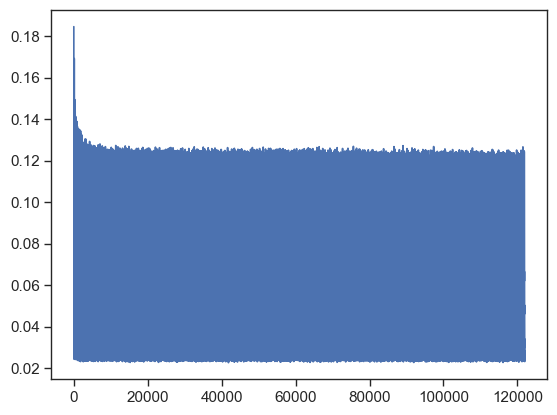

In [16]:
spa_ae, loss_list = pipeline.train_autoencoder(loader, spa_ae, lr=1e-4, weight_decay=1e-5, n_epochs=1000)
torch.save(spa_ae, os.path.join(model_config["save_dir"], "autoencoder.pth"))
plt.plot(loss_list)

In [17]:
spa_ae = torch.load(os.path.join(model_config["save_dir"], "autoencoder.pth"))

In [18]:
with torch.no_grad():
    spa_ae.eval()
    with torch.no_grad():
        z, out = spa_ae(data.x.to(device), data.edge_index.to(device))
    adata.obsm["latent"] = z.detach().cpu().numpy()


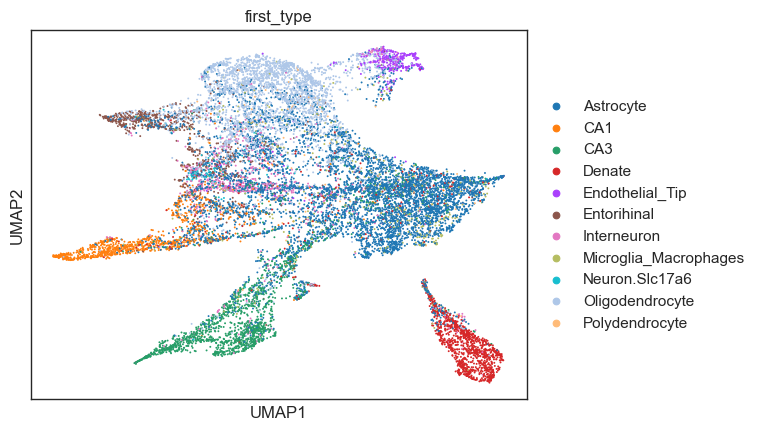

In [36]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep="latent")
sc.tl.umap(adata, min_dist=0.2)
sc.pl.umap(adata, color=["first_type"])

## Training the diffusion model

In [78]:
def evaluate_denoise_net(adata, denoise_net, niose_scheduler, spatial, labels,
                              n_features=32, save_dir=None, name=None, progress=True):
    simulated = pipeline.simulate(denoise_net, niose_scheduler, spatial, labels=labels,
                              n_features=n_features, progress=progress)
    simulated = simulated.cpu().numpy()
    adata_sim = sc.AnnData(simulated)
    sc.pp.neighbors(adata_sim, n_neighbors=30)
    sc.tl.umap(adata_sim, min_dist=0.2)
    adata_sim.obs["cell_type"] = adata.obs["first_type"].values
    adata_sim.obs["labels"] = labels.cpu().numpy()
    adata_sim.obsm["spatial"] = adata.obsm["spatial"].copy()
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    sc.pl.umap(adata_sim, color=["cell_type"], show=False, ax=ax, frameon=False)
    plt.tight_layout()
    if save_dir is not None:
        fig.savefig(os.path.join(save_dir, name + ".png"), dpi=300)
    return adata_sim

In [23]:
normalizer = utils.MinMaxNormalize(adata.obsm["latent"], dim=0)
adata.obsm["normalized_latent"] = normalizer.normalize(adata.obsm["latent"])

In [24]:
# adata.obs["cell_type"] = adata.obs["first_type"].cat.codes
adata.write_h5ad(os.path.join(model_config["save_dir"], "J20_hippocampus_rep3.h5ad"))
# adata = sc.read_h5ad('E:\Projects\diffusion\output\Hippocampus_condition\J20_hippocampus_rep3.h5ad')

In [25]:
data_latent = prepare_dataset(adata, use_rep="normalized_latent", use_spatial="spatial_new", use_net="Spatial_Net",
                                       use_label="cell_type")
loader = NeighborLoader(data_latent, num_neighbors=[5, 5], batch_size=64)

In [32]:
1 % 100

1

  0%|          | 0/2000 [00:00<?, ?it/s]

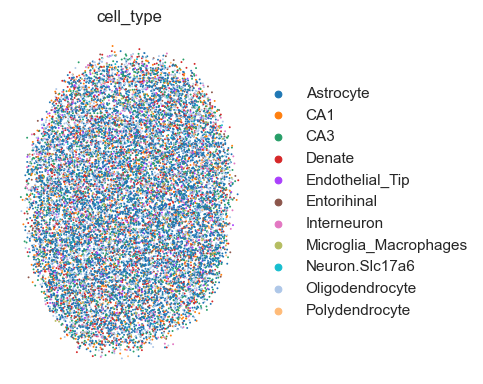

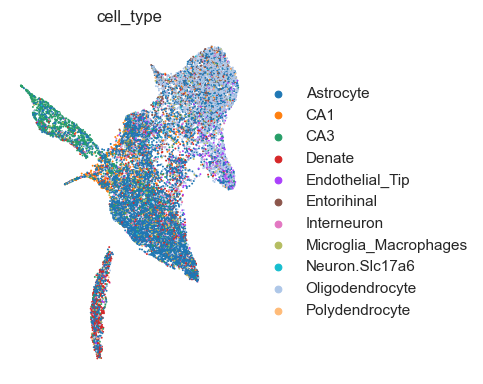

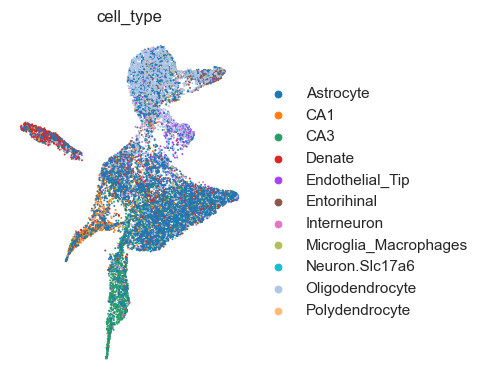

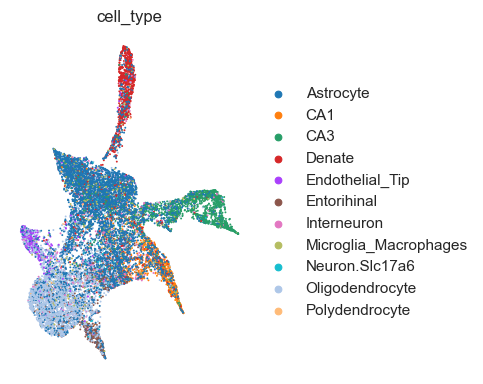

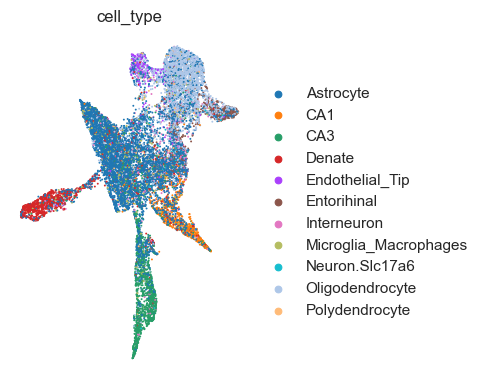

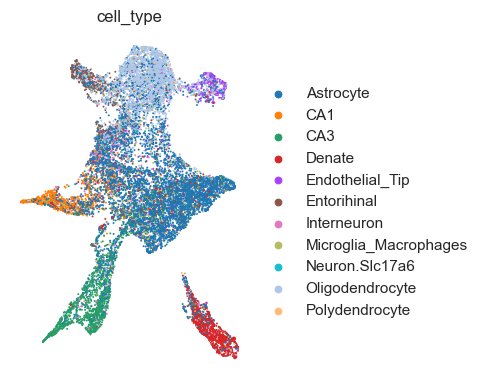

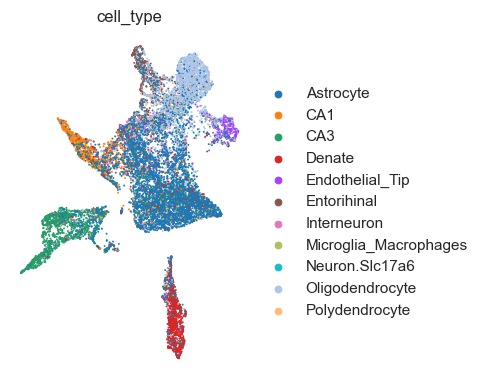

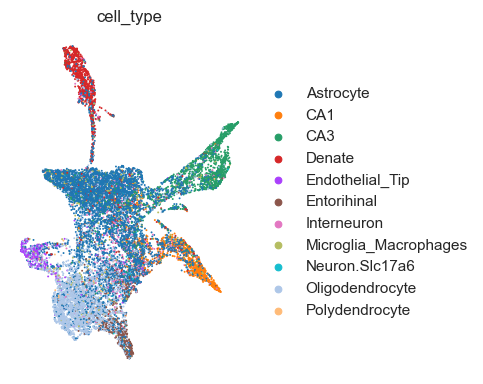

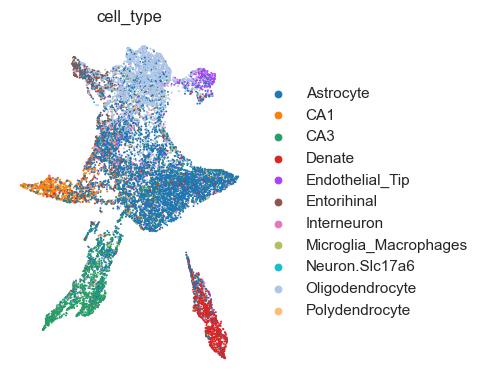

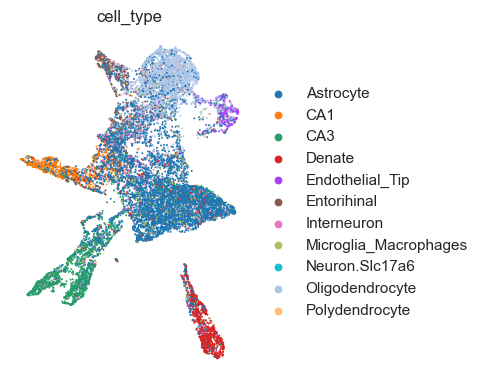

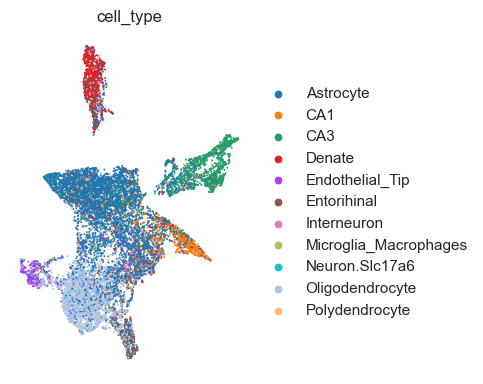

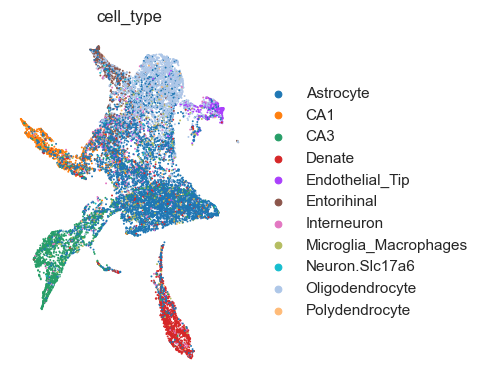

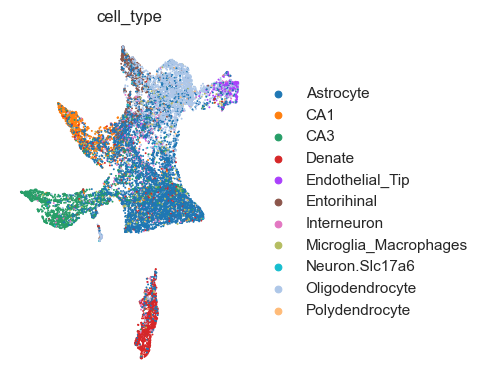

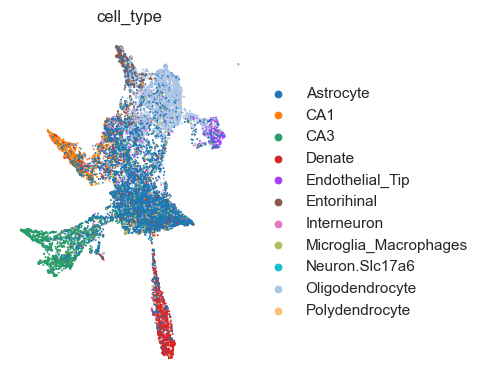

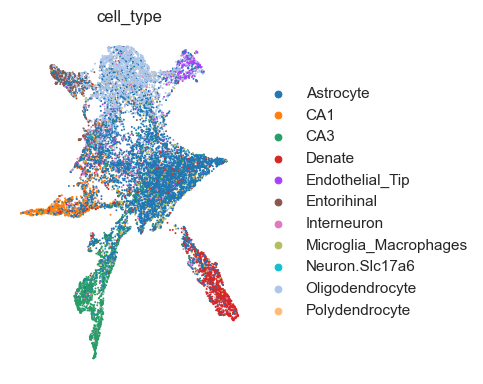

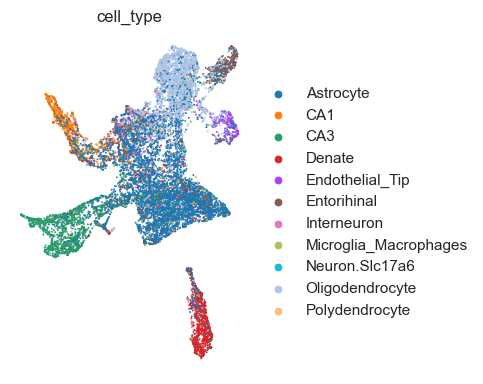

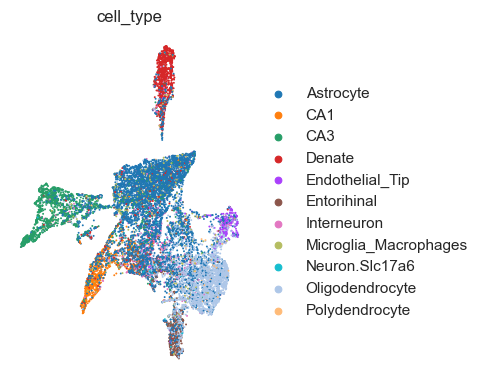

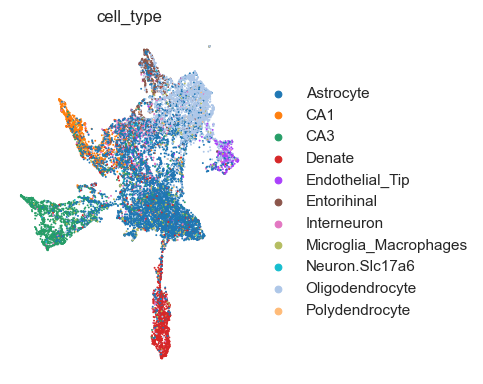

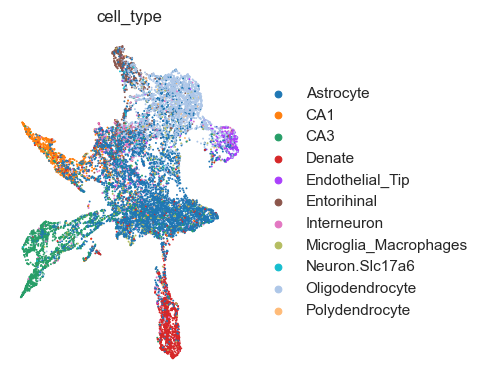

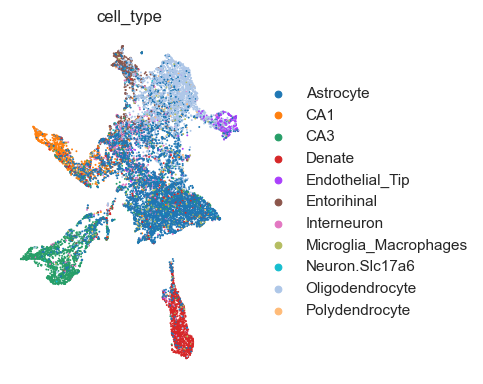

In [35]:
num_class_embeds = len(adata.obs["first_type"].unique())
denoise_net = SpaUNet1DModel(in_channels=17, out_channels=1, num_class_embeds=num_class_embeds).to(device)
optimizer = torch.optim.AdamW(denoise_net.parameters(), lr=1e-4, weight_decay=1e-6)
niose_scheduler = DDPMScheduler(num_train_timesteps=1000)
n_epochs = 2000
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
pbar = tqdm(range(n_epochs))
evaluate_interval = 100
logging = defaultdict(list)
for epoch in range(1, n_epochs+1):
    for batch_id, batch in enumerate(loader):
        batch = batch.to(device)
        clean_data = batch.x
        clean_data = clean_data.unsqueeze(1) # (batch_size, 1, num_channels)
        optimizer.zero_grad()
        noise = torch.randn_like(clean_data)
        timesteps = torch.randint(0, 1000, (clean_data.shape[0],), device=batch.x.device, dtype=torch.long, )
        noisy_data = niose_scheduler.add_noise(clean_data, noise, timesteps)
        noise_pred = denoise_net(noisy_data, timesteps, batch.spatial.to(device)).sample
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        logging["loss"].append(loss.item())
        # clip gradient
        torch.nn.utils.clip_grad_norm_(denoise_net.parameters(), 5)
        optimizer.step()
        lr_scheduler.step()
        pbar.set_description(f"Epoch: {epoch}, Loss: {loss.item():.4f}, batch_id: {batch_id}")
    pbar.update(1)
    if epoch % evaluate_interval == 1:
        evaluate_denoise_net(adata, denoise_net, niose_scheduler, data_latent.spatial, labels=data_latent.label,
                             n_features=32, save_dir=os.path.join(model_config["save_dir"], "figures"),
                             name="embedding" + str(epoch // 100) + "h", progress=False)

In [37]:
torch.save(denoise_net, os.path.join(model_config["save_dir"], "denoise_net.pth"))

  0%|          | 0/1000 [00:00<?, ?it/s]

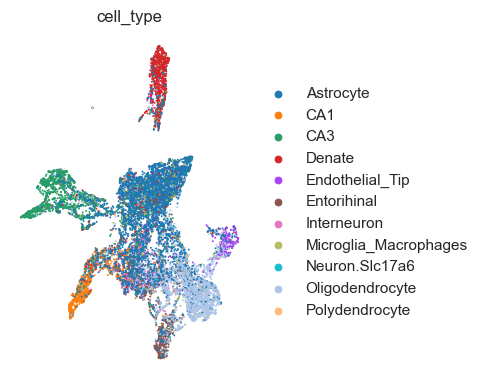

In [41]:
adata_sim = evaluate_denoise_net(adata, denoise_net, niose_scheduler, data_latent.spatial, labels=data_latent.label,
                             n_features=32, progress=True)

In [43]:
adata_sim.X = normalizer.denormalize(adata_sim.X)
# perform umap
sc.pp.neighbors(adata_sim, n_neighbors=30)
sc.tl.umap(adata_sim, min_dist=0.5)

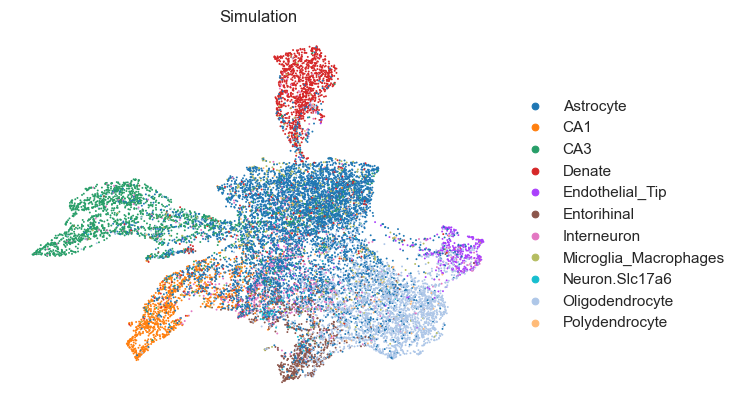

In [48]:
sc.pl.umap(adata_sim, color=["cell_type"], ncols=1, frameon=False, wspace=0.4, use_raw=False, title="Simulation")

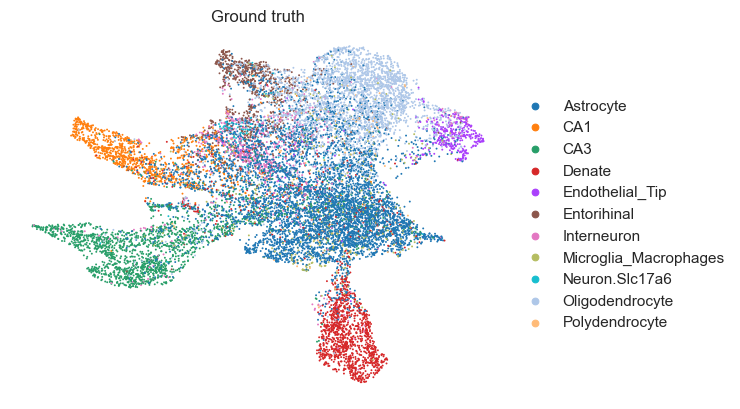

In [47]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep="latent")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["first_type"], ncols=1, frameon=False, wspace=0.4, use_raw=False, title="Ground truth")

## Evaluation the cell type
How the cell type guide the diffusion process?

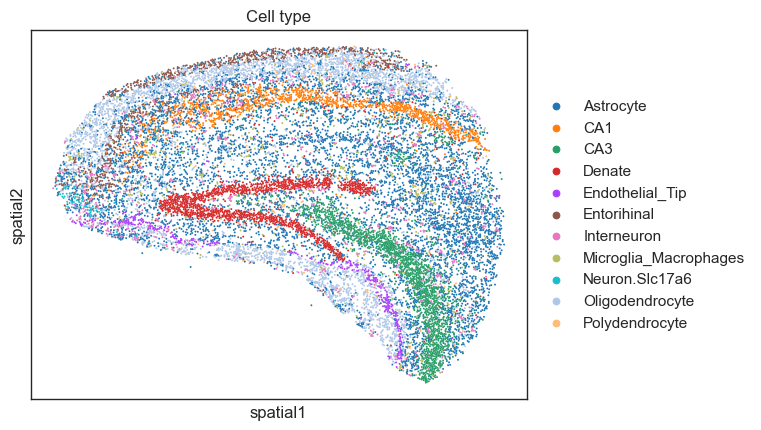

In [57]:
sc.pl.embedding(adata_sim, basis="spatial", color="cell_type", title="Cell type")

In [68]:
# shuffle data_latent.label
# get a dict of "cell_type": "first_type" from adata.obs columns
cell_type_dict = dict(zip(adata.obs["cell_type"].values, adata.obs["first_type"].values))
# swap "Denate" and "CA3"
# copy dict
cell_type_dict

{2: 'CA3',
 3: 'Denate',
 1: 'CA1',
 8: 'Neuron.Slc17a6',
 6: 'Interneuron',
 5: 'Entorihinal',
 9: 'Oligodendrocyte',
 0: 'Astrocyte',
 7: 'Microglia_Macrophages',
 10: 'Polydendrocyte',
 4: 'Endothelial_Tip'}

In [85]:
# copy data_latent.label to pesudo_labels
pesudo_labels = torch.clone(data_latent.label)
index_CA3 = pesudo_labels == 2
index_Denate = pesudo_labels == 3
pesudo_labels[index_CA3] = 3
pesudo_labels[index_Denate] = 2

  0%|          | 0/1000 [00:00<?, ?it/s]

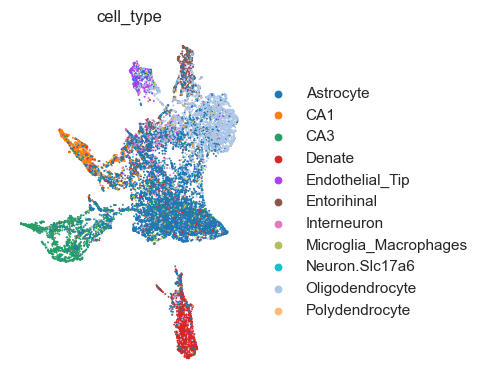

In [86]:
adata_sim_pesudo = evaluate_denoise_net(adata, denoise_net, niose_scheduler, data_latent.spatial, labels=pesudo_labels,
                             n_features=32, progress=True)

In [87]:
adata_sim_pesudo.X = normalizer.denormalize(adata_sim_pesudo.X)
# perform umap
sc.pp.neighbors(adata_sim_pesudo, n_neighbors=30)
sc.tl.umap(adata_sim_pesudo, min_dist=0.5)
adata_sim_pesudo.obs["labels"] = pesudo_labels.cpu().numpy().astype(str)


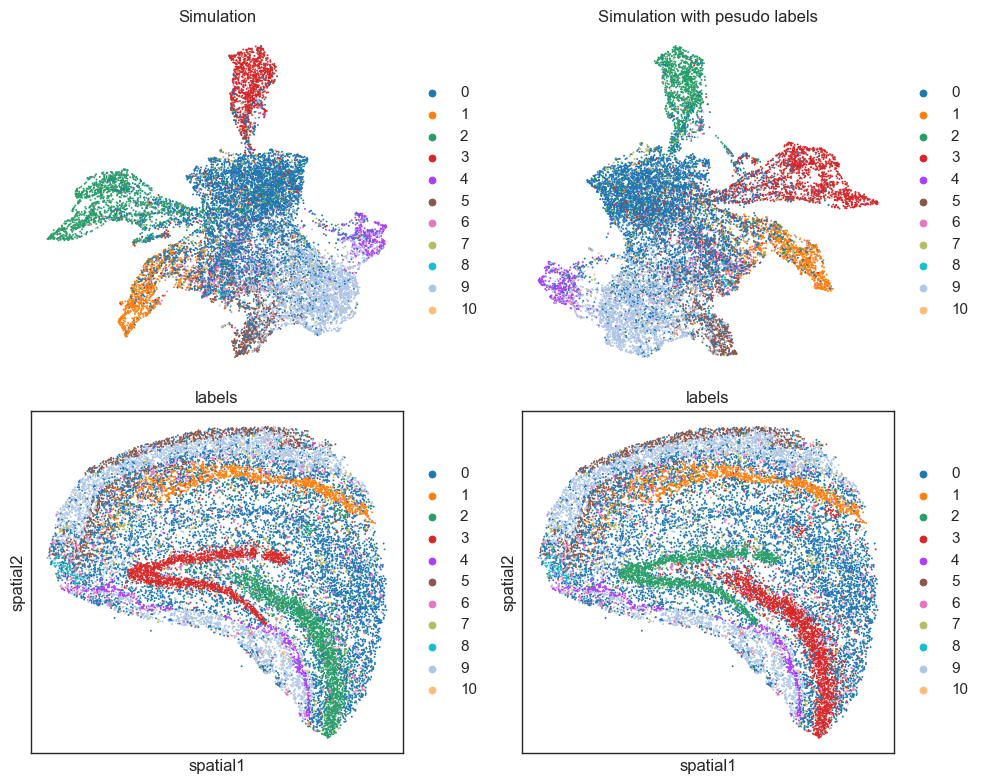

In [90]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sc.pl.umap(adata_sim, color=["labels"], show=False, ax=axes[0, 0], frameon=False)
axes[0, 0].set_title("Simulation")
sc.pl.umap(adata_sim_pesudo, color=["labels"], show=False, ax=axes[0, 1], frameon=False)
axes[0, 1].set_title("Simulation with pesudo labels")
sc.pl.embedding(adata_sim, basis="spatial", color="labels", show=False, ax=axes[1, 0])
sc.pl.embedding(adata_sim_pesudo, basis="spatial", color="labels", show=False, ax=axes[1, 1])
plt.tight_layout()

In [94]:
adata_sim1 = adata_sim[adata_sim.obs["labels"].isin(["2", "3"]), :]
adata_sim2 = adata_sim_pesudo[adata_sim_pesudo.obs["labels"].isin(["2", "3"]), :]
adata_sim2.obs["labels"] = adata_sim2.obs["labels"].apply(lambda x: x + "_pesudo")
adata_sim_comb = adata_sim1.concatenate(adata_sim2)

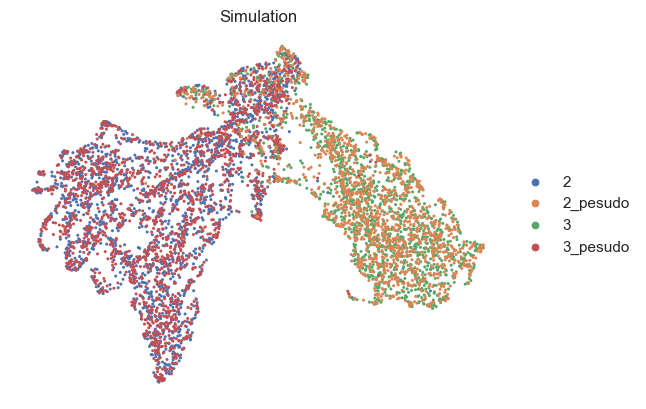

In [95]:
# perform UMAP
sc.pp.neighbors(adata_sim_comb, n_neighbors=30)
sc.tl.umap(adata_sim_comb, min_dist=0.5)
sc.pl.umap(adata_sim_comb, color=["labels"], ncols=1, frameon=False, wspace=0.4, use_raw=False, title="Simulation")